In [ ]:
import os, sys, math, time, json, random, csv, gc
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import Dataset
from transformers import (
    AutoConfig, AutoTokenizer, AutoModelForCausalLM,
    DataCollatorForLanguageModeling, TrainingArguments, Trainer
)
from transformers.trainer_callback import TrainerCallback, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model

# ----------------------------
# CONFIGURACIÓN
# ----------------------------
MODEL_ID = os.getenv("MODEL_ID", "meta-llama/Llama-3.2-3B-Instruct")   
HF_TOKEN = os.getenv("HF_TOKEN", None)                                  
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"

CUT_OFF_LEN     = int(os.getenv("CUT_OFF_LEN", "1024"))
MAX_NEW_TOKENS  = int(os.getenv("MAX_NEW_TOKENS", "512"))
TEMPERATURE     = float(os.getenv("TEMPERATURE", "0.2"))
TOP_P           = float(os.getenv("TOP_P", "0.9"))
N_TRAIN         = int(os.getenv("N_TRAIN", "1500"))                     # subset de train
EVAL_STEPS      = int(os.getenv("EVAL_STEPS", "10"))
LOG_STEPS       = int(os.getenv("LOG_STEPS", "10"))
SAVE_STEPS      = int(os.getenv("SAVE_STEPS", "100"))
NUM_EPOCHS      = int(os.getenv("NUM_EPOCHS", "3"))
BATCH_TRAIN     = int(os.getenv("BATCH_TRAIN", "2"))
BATCH_EVAL      = int(os.getenv("BATCH_EVAL", "2"))
GRAD_ACC_STEPS  = int(os.getenv("GRAD_ACC_STEPS", "16"))
LR              = float(os.getenv("LR", "1e-4"))
WARMUP_RATIO    = float(os.getenv("WARMUP_RATIO", "0.05"))
SEED            = int(os.getenv("SEED", "42"))

# LoRA
LORA_R          = int(os.getenv("LORA_R", "16"))
LORA_ALPHA      = int(os.getenv("LORA_ALPHA", "32"))
LORA_DROPOUT    = float(os.getenv("LORA_DROPOUT", "0.05"))

# Métricas
LOSS_WEIGHTS    = [0.3, 0.3, 0.2, 0.1, 0.1]

# Salidas
SAFE_MODEL_NAME = MODEL_ID.replace("/", "__")
OUTPUT_DIR   = os.getenv("OUTPUT_DIR", f"outputs/{SAFE_MODEL_NAME}-lora-fp16")
METRICS_CSV  = f"{OUTPUT_DIR}/train_val_metrics.csv"
PLOT_PATH    = f"{OUTPUT_DIR}/loss_curves.png"
FINAL_DIR    = f"{OUTPUT_DIR}/final"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FINAL_DIR, exist_ok=True)

# Otros
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.set_float32_matmul_precision("high")
print("Device:", DEVICE, "| GPU:", torch.cuda.get_device_name(0) if DEVICE=="cuda" else "CPU")
print("Model:", MODEL_ID)

d:\OneDrive\Documents\MAIA\Semestre 4\Despliegue de Soluciones\__REPOS__\Generacion-de-resumenes.-medicos\.venv_generacion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda | GPU: NVIDIA GeForce RTX 3090
Model: meta-llama/Llama-3.2-3B-Instruct


## Configurar el wrapper de métricas y funcion de pérdidas

In [2]:
# Busca la carpeta 'metricas' hacia arriba y añade a sys.path
HERE = Path.cwd()
found = None
for p in [HERE] + list(HERE.parents):
    if (p / "metricas").is_dir():
        found = p
        break
if not found:
    raise RuntimeError("No se encontró la carpeta 'metricas' en ningún ancestro.")
if str(found) not in sys.path:
    sys.path.insert(0, str(found))

from metricas.metrics_client import getLoss  # usa http://localhost:8000

@torch.no_grad()
def eval_composite_loss(model, tokenizer, val_df, sample_size=64):
    if len(val_df) == 0:
        return None
    sub = val_df.sample(n=min(sample_size, len(val_df)), random_state=SEED).reset_index(drop=True)

    prompts = [
        tokenizer.apply_chat_template(
            [{"role": "system", "content": SYSTEM_PROMPT},
             {"role": "user",   "content": USER_PREFIX + s}],
            tokenize=False, add_generation_prompt=True
        )
        for s in sub["source_text"].tolist()
    ]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=CUT_OFF_LEN).to(DEVICE)
    gen = model.generate(
        **inputs, max_new_tokens=MAX_NEW_TOKENS, do_sample=True,
        temperature=TEMPERATURE, top_p=TOP_P
    )
    outs = tokenizer.batch_decode(gen[:, inputs["input_ids"].shape[1]:], skip_special_tokens=True)

    losses = getLoss(
        sub["source_text"].tolist(),
        sub["target_text"].tolist(),
        outs,
        weights=LOSS_WEIGHTS
    )
    if isinstance(losses, list):
        return float(sum(losses)/len(losses))
    return float(losses)

## Carga y repartición de los datos

In [3]:
CSV_PATH = os.getenv("CSV_PATH", "../../data/pls_abstract_pairs_with_metrics.csv")
df = pd.read_csv(CSV_PATH)

# Split en val/test
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "test"].reset_index(drop=True)

if N_TRAIN:
    train_df = train_df.sample(n=min(N_TRAIN, len(train_df)), random_state=SEED).reset_index(drop=True)

print(f"Train: {len(train_df)} pares \nVal: {len(val_df)} pares")

Train: 1500 pares 
Val: 218 pares


## Definir Tokenización

In [ ]:
SYSTEM_PROMPT = (
    "You simplify clinical trial protocol text into a plain-language summary for the general public. "
    "Keep to 6–8th grade readability, avoid diagnoses and speculation, no hallucinations, "
    "and preserve key facts (objective, population, interventions, outcomes, timelines, safety)."
)
USER_PREFIX = "Using the following clinical trial protocol text as input, create a plain language summary.\n\n"

def build_chat(src: str, tgt: str):
    return [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": USER_PREFIX + str(src)},
        {"role": "assistant", "content": str(tgt)},
    ]

def encode_supervised(batch, tokenizer):
    chats = [build_chat(s, t) for s, t in zip(batch["source_text"], batch["target_text"])]
    if hasattr(tokenizer, "apply_chat_template"):
        texts = [tokenizer.apply_chat_template(c, tokenize=False, add_generation_prompt=False) for c in chats]
    else:
        texts = [
            f"<<SYS>> {SYSTEM_PROMPT} <</SYS>>\n[INST] {USER_PREFIX}{s} [/INST] {t}"
            for s, t in zip(batch["source_text"], batch["target_text"])
        ]
    out = tokenizer(texts, truncation=True, max_length=CUT_OFF_LEN, padding=False)
    return out


In [5]:
def load_tokenizer(model_id: str, hf_token: str | None = HF_TOKEN):
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True, token=hf_token, trust_remote_code=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    tok.padding_side = "right"
    return tok

def load_causallm(model_id: str, device: str = DEVICE, hf_token: str | None = HF_TOKEN):
    # Verifica que sea un modelo de lenguaje causal compatible (no VL)
    try:
        cfg = AutoConfig.from_pretrained(model_id, trust_remote_code=True, token=hf_token)
        arch_ok = any("CausalLM" in a for a in getattr(cfg, "architectures", []) or [])
    except Exception:
        arch_ok = True  # algunos repos no exponen architectures; intentamos cargar de todas formas

    model = AutoModelForCausalLM.from_pretrained(
        model_id, torch_dtype=torch.float16 if device.startswith("cuda") else torch.float32,
        trust_remote_code=True, token=hf_token
    ).to(device)

    # Si no es CausalLM, esto normalmente falla al forward; advertimos:
    if not arch_ok:
        print("[WARN] El repo no declara arquitectura CausalLM. Si falla el forward, usar un modelo TEXT (no VL).")

    model.config.use_cache = False
    return model

tokenizer = load_tokenizer(MODEL_ID)
model     = load_causallm(MODEL_ID)
print("Tokenizer & model listos. Device:", next(model.parameters()).device)


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Tokenizer & model listos. Device: cuda:0


## Data Collator

In [6]:
hf_train = Dataset.from_pandas(train_df[["source_text","target_text"]]).map(
    lambda b: encode_supervised(b, tokenizer), batched=True, remove_columns=["source_text","target_text"]
)
hf_val = Dataset.from_pandas(val_df[["source_text","target_text"]]).map(
    lambda b: encode_supervised(b, tokenizer), batched=True, remove_columns=["source_text","target_text"]
)

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
print(hf_train, hf_val)


Map: 100%|██████████| 218/218 [00:00<00:00, 1849.18 examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1500
}) Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 218
})


## LoRa

In [7]:
def auto_find_lora_targets(model, extra_patterns=None):
    common = {
        "q_proj","k_proj","v_proj","o_proj",
        "gate_proj","up_proj","down_proj",
        "wi","wo","wq","wk","wv","W_pack","query_key_value"
    }
    if extra_patterns:
        common |= set(extra_patterns)
    found = set()
    for name, module in model.named_modules():
        base = name.split(".")[-1]
        if base in common:
            found.add(base)
    if not found:
        found = {"q_proj","k_proj","v_proj","o_proj"}
    return sorted(found)

targets = auto_find_lora_targets(model)
print("LoRA targets:", targets)

lora_cfg = LoraConfig(
    r=LORA_R, lora_alpha=LORA_ALPHA, lora_dropout=LORA_DROPOUT,
    bias="none", task_type="CAUSAL_LM", target_modules=targets
)
model = get_peft_model(model, lora_cfg)
model.gradient_checkpointing_enable()
model.enable_input_require_grads()
model.config.pad_token_id = tokenizer.pad_token_id
model.train()

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable: {trainable/1e6:.2f}M / {total/1e6:.2f}M ({100*trainable/total:.2f}%)")


LoRA targets: ['down_proj', 'gate_proj', 'k_proj', 'o_proj', 'q_proj', 'up_proj', 'v_proj']
Trainable: 24.31M / 3237.06M (0.75%)


## Logging

In [8]:
class TrainValCSVLogger(TrainerCallback):
    def __init__(self, csv_path=METRICS_CSV):
        self.csv_path = csv_path
        os.makedirs(os.path.dirname(self.csv_path), exist_ok=True)
        if not os.path.exists(self.csv_path):
            with open(self.csv_path, "w", newline="") as f:
                csv.writer(f).writerow(["step","train_loss","eval_loss","lr","timestamp","composite_loss"])

    def on_log(self, args, state, control, **kwargs):
        logs = kwargs.get("logs", {})
        step = state.global_step
        tl   = logs.get("loss")
        el   = logs.get("eval_loss")
        lr   = logs.get("learning_rate")
        with open(self.csv_path, "a", newline="") as f:
            csv.writer(f).writerow([step, tl, el, lr, time.time(), None])

    def on_evaluate(self, args, state, control, **kwargs):
        comp = eval_composite_loss(kwargs["model"], tokenizer, val_df)
        with open(self.csv_path, "a", newline="") as f:
            csv.writer(f).writerow([state.global_step, None, kwargs["metrics"].get("eval_loss"), None, time.time(), comp])

early_stop = EarlyStoppingCallback(early_stopping_patience=4, early_stopping_threshold=1e-4)
csv_logger = TrainValCSVLogger(METRICS_CSV)

## PEFT (Ajuste Fino)

In [9]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRAD_ACC_STEPS,
    num_train_epochs=NUM_EPOCHS,
    fp16=(DEVICE=="cuda"),
    learning_rate=LR,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type="cosine",
    logging_strategy="steps",
    logging_first_step=True,
    logging_steps=LOG_STEPS,
    eval_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    optim="adamw_torch",
    report_to="none",
    disable_tqdm=False,
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    data_collator=data_collator,
)

trainer.add_callback(csv_logger)
trainer.add_callback(early_stop)

approx_steps = math.ceil(len(hf_train) / max(1, BATCH_TRAIN) / max(1, GRAD_ACC_STEPS)) * NUM_EPOCHS
print("Aprox. training steps:", approx_steps)

torch.cuda.empty_cache()
trainer.train()


Aprox. training steps: 141


Step,Training Loss,Validation Loss
10,2.066000,1.791688
20,1.668600,1.521460
30,1.481100,1.442140
40,1.442800,1.416911
50,1.403100,1.400903
60,1.389700,1.389487
70,1.392400,1.379947
80,1.386800,1.372575
90,1.371500,1.365957
100,1.344300,1.360445


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

TrainOutput(global_step=141, training_loss=1.4532050689061482, metrics={'train_runtime': 12437.1923, 'train_samples_per_second': 0.362, 'train_steps_per_second': 0.011, 'total_flos': 7.85962917340201e+16, 'train_loss': 1.4532050689061482, 'epoch': 3.0})

## Guardado y demo de inferencia

In [10]:
# Guardado final (PEFT adapters + tokenizer)
trainer.model.save_pretrained(FINAL_DIR)
tokenizer.save_pretrained(FINAL_DIR)
print("Guardado en:", FINAL_DIR)

# Demo de inferencia corta y estable (greedy + anti-repetición)
demo_src = val_df.iloc[0]["source_text"]
prompt = tokenizer.apply_chat_template(
    [{"role":"system","content":SYSTEM_PROMPT},
     {"role":"user","content":USER_PREFIX + demo_src}],
    tokenize=False, add_generation_prompt=True
)

print(demo_src)

print("\n\n", "RESUMEN GENERADO POR IA:", "\n\n")

model.eval()
inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    gen = model.generate(
        **inputs,
        max_new_tokens=min(MAX_NEW_TOKENS, 256),
        do_sample=False,
        no_repeat_ngram_size=6,
        repetition_penalty=1.15,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id
    )
print(tokenizer.decode(gen[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Guardado en: outputs/meta-llama__Llama-3.2-3B-Instruct-lora-fp16/final
Background
Urinary schistosomiasis is caused by an intravascular infection with parasitic Schistosoma haematobium worms. The adult worms typically migrate to the venous plexus of the human bladder and excrete eggs which the infected person passes in their urine. Chronic infection can cause substantial morbidity and long‐term complications as the eggs become trapped in human tissues causing inflammation and fibrosis. We summarised evidence of drugs active against the infection. This is new edition of a review first published in 1997. 
Objectives
To evaluate the efficacy and safety of drugs for treating urinary schistosomiasis.
Search methods
We searched the Cochrane Infectious Diseases Group Specialized Register, MEDLINE, CENTRAL, EMBASE and LILACS and reference lists of articles up to 23 May 2014. 
Selection criteria
Randomized controlled trials (RCTs) of antischistosomal drugs and drug combinations compared to plac

## Gráfica de rendimiento (entrenamiento v.s. validación)

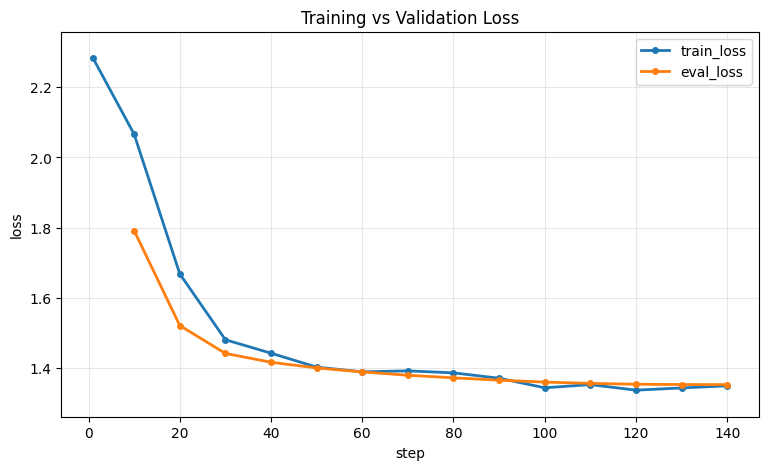

Plot guardado en: outputs/meta-llama__Llama-3.2-3B-Instruct-lora-fp16/loss_curves.png
Métricas CSV: outputs/meta-llama__Llama-3.2-3B-Instruct-lora-fp16/train_val_metrics.csv


In [11]:
dfm = pd.read_csv(METRICS_CSV)
for c in ("step","train_loss","eval_loss","lr"):
    if c in dfm.columns: dfm[c] = pd.to_numeric(dfm[c], errors="coerce")
dfm = dfm.dropna(subset=["train_loss","eval_loss","lr"], how="all")
dfm = dfm.sort_values("step").groupby("step", as_index=False).last()

xs_tr = dfm["step"].to_numpy()
ys_tr = dfm["train_loss"].to_numpy()
xs_ev = dfm["step"].to_numpy()
ys_ev = dfm["eval_loss"].to_numpy()

plt.figure(figsize=(9,5))
if np.isfinite(ys_tr).any(): plt.plot(xs_tr, ys_tr, "-o", label="train_loss", lw=2, ms=4)
if np.isfinite(ys_ev).any(): plt.plot(xs_ev, ys_ev, "-o", label="eval_loss",  lw=2, ms=4)

vals = np.concatenate([a[~np.isnan(a)] for a in [ys_tr, ys_ev] if len(a)])
if len(vals):
    pad = max(1e-4, 0.08*(vals.max()-vals.min()))
    plt.ylim(vals.min()-pad, vals.max()+pad)

plt.title(f"Training vs Validation Loss — {SAFE_MODEL_NAME}")
plt.xlabel("step"); plt.ylabel("loss"); plt.title("Training vs Validation Loss")
plt.grid(alpha=0.3); plt.legend()
plt.savefig(PLOT_PATH, dpi=150, bbox_inches="tight")
plt.show()

print("Plot guardado en:", PLOT_PATH)
print("Métricas CSV:", METRICS_CSV)

## Experimento (mlflow -> Databricks)

In [12]:
# import mlflow
# from datetime import datetime

# # Configuración MLflow
# # - Local: exporta MLFLOW_TRACKING_URI="file:./mlruns"  (por defecto mlflow lo hace local)
# # - Databricks: exporta MLFLOW_TRACKING_URI="databricks" y los tokens (DATABRICKS_HOST, DATABRICKS_TOKEN)
# mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "file:./mlruns"))
# mlflow.set_experiment(os.getenv("MLFLOW_EXPERIMENT", f"/{SAFE_MODEL_NAME}"))

# run_name = f"{SAFE_MODEL_NAME}-{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# with mlflow.start_run(run_name=run_name):
#     # Params clave
#     mlflow.log_params({
#         "model_id": MODEL_ID,
#         "fp16": (DEVICE=="cuda"),
#         "cut_off_len": CUT_OFF_LEN,
#         "max_new_tokens": MAX_NEW_TOKENS,
#         "temperature": TEMPERATURE,
#         "top_p": TOP_P,
#         "epochs": NUM_EPOCHS,
#         "batch_train": BATCH_TRAIN,
#         "batch_eval": BATCH_EVAL,
#         "grad_acc_steps": GRAD_ACC_STEPS,
#         "lr": LR,
#         "warmup_ratio": WARMUP_RATIO,
#         "seed": SEED,
#         "lora_r": LORA_R,
#         "lora_alpha": LORA_ALPHA,
#         "lora_dropout": LORA_DROPOUT,
#         "lora_targets": json.dumps(auto_find_lora_targets(model), ensure_ascii=False),
#         "loss_weights": json.dumps(LOSS_WEIGHTS),
#         "n_train_rows": len(train_df),
#         "n_val_rows": len(val_df),
#     })

#     # Métricas finales (si existen en CSV)
#     try:
#         df_metrics = pd.read_csv(METRICS_CSV)
#         for c in ("step","train_loss","eval_loss"):
#             if c in df_metrics.columns:
#                 df_metrics[c] = pd.to_numeric(df_metrics[c], errors="coerce")
#         last_train = df_metrics["train_loss"].dropna().iloc[-1] if "train_loss" in df_metrics and df_metrics["train_loss"].notna().any() else None
#         last_eval  = df_metrics["eval_loss"].dropna().iloc[-1]  if "eval_loss" in df_metrics and df_metrics["eval_loss"].notna().any() else None
#         if last_train is not None: mlflow.log_metric("train_loss_last", float(last_train))
#         if last_eval  is not None: mlflow.log_metric("eval_loss_last",  float(last_eval))
#     except Exception as e:
#         print("[MLflow] Aviso: no pude leer métricas CSV:", e)

#     # Artefactos
#     if os.path.exists(METRICS_CSV): mlflow.log_artifact(METRICS_CSV, artifact_path="metrics")
#     if os.path.exists(PLOT_PATH):    mlflow.log_artifact(PLOT_PATH,    artifact_path="plots")

#     # Guarda adapters y tokenizer como artefactos
#     mlflow.log_artifacts(FINAL_DIR, artifact_path="model_final")

# print("MLflow: experimento registrado. Tracking URI:", mlflow.get_tracking_uri())


In [13]:
from IPython.display import Markdown

def export_code_cells():
    from IPython import get_ipython
    cells = get_ipython().user_ns['In']
    code = '\n\n'.join([c for c in cells if c.strip()])
    return Markdown(f'```python\n{code}\n```')

#export_code_cells()